In [1]:
import os
import pywt
import torch
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from quantus.metrics import Complexity
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [10]:
# evaluate wavelet
fs = 100
batch_size = 128
wavelet = 'db'
w_len = 3
level = pywt.dwt_max_level(fs, 'db3')
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_db3_4_128


In [4]:
# read data
folder = 'public/simple/'
path = f'{folder}_wavelets_cpu.pkl'

with open(path, 'rb') as f:
    attributions = pickle.load(f)
print(f"Attributions loaded from {path}")

Attributions loaded from public/simple/_wavelets_cpu.pkl


In [5]:
# print the type of attributions[key_]
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_6_128', 'filtermasks_wavelet_db1_6_128', 'wavelet_db2_5_128', 'filtermasks_wavelet_db2_5_128', 'wavelet_db3_4_128', 'filtermasks_wavelet_db3_4_128', 'wavelet_db4_3_128', 'filtermasks_wavelet_db4_3_128', 'wavelet_sym2_5_128', 'filtermasks_wavelet_sym2_5_128', 'wavelet_sym3_4_128', 'filtermasks_wavelet_sym3_4_128', 'wavelet_sym4_3_128', 'filtermasks_wavelet_sym4_3_128', 'wavelet_coif1_4_128', 'filtermasks_wavelet_coif1_4_128', 'wavelet_coif2_3_128', 'filtermasks_wavelet_coif2_3_128', 'wavelet_coif3_2_128', 'filtermasks_wavelet_coif3_2_128'])


In [6]:
key_ = 'wavelet_db1_6_128'
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))
print(len(attributions[key_][0][0][0][0]))

<class 'list'>
79
128
1
100
7


In [7]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))
print(len(attributions[key_2][0][0][0]))

<class 'list'>
79
128
100
7


In [9]:
set_seed(42)

# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

wavelet_db1_6_128
[0.5, 0.7369, 0.7982, 0.8795, 0.896, 0.9001, 0.8998, 0.9002, 0.9004, 0.9007, 0.9023, 0.9161, 0.9464, 0.9707, 0.9884, 0.9969, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.49999999709129334, 0.747115301990509, 0.7882471662521362, 0.8433427346229553, 0.8625843976974488, 0.8677137631416321, 0.8689318758010864, 0.8697356504440308, 0.8705457429885864, 0.8708537595748901, 0.87270719165802, 0.8786342793464661, 0.8924514278411865, 0.9188434199333191, 0.9553225690841675, 0.9826194231033325, 0.9967146850585937, 0.9998255815505982, 0.9999973869323731, 0.9999993744850159, 0.9999994623184204]
[51.703160881996155, 15.849346786737442, 12.627000577747822, 8.762470498681068, 7.6248030588030815, 7.323620554059744, 7.270344730466604, 7.231539253145456, 7.202779062092304, 7.190829329192638, 7.018517956137657, 6.506527245044708, 5.552524626255035, 4.03219186514616, 2.1207421738654375, 0.7866579371038824, 0.13624728395370767, 0.006867224077723222, 0.00010368597259002854, 2.484067017860525e-05, 2.12252887195

In [11]:
# from a log output the complexities are
print("Complexities: {'wavelet_db1_6_128': [np.float64(3.1501425132531957)], 'wavelet_db2_5_128': [np.float64(2.7429121066628666)], 'wavelet_db3_4_128': [np.float64(2.8101461932472898)], 'wavelet_db4_3_128': [np.float64(2.5610993173601226)], 'wavelet_sym2_5_128': [np.float64(2.7429121066628666)], 'wavelet_sym3_4_128': [np.float64(2.8101461932472898)], 'wavelet_sym4_3_128': [np.float64(2.5750239188673842)], 'wavelet_coif1_4_128': [np.float64(2.8758760678155997)], 'wavelet_coif2_3_128': [np.float64(2.562376315226119)], 'wavelet_coif3_2_128': [np.float64(2.1871345450988877)]}")
print("Grad complexities: {'wavelet_db1_6_128': [np.float32(0.5566059)], 'wavelet_db2_5_128': [np.float32(0.5100968)], 'wavelet_db3_4_128': [np.float32(0.5107855)], 'wavelet_db4_3_128': [np.float32(0.39473084)], 'wavelet_sym2_5_128': [np.float32(0.5100968)], 'wavelet_sym3_4_128': [np.float32(0.5107855)], 'wavelet_sym4_3_128': [np.float32(0.42864695)], 'wavelet_coif1_4_128': [np.float32(0.51240665)], 'wavelet_coif2_3_128': [np.float32(0.50978905)], 'wavelet_coif3_2_128': [np.float32(0.37444177)]}")

Complexities: {'wavelet_db1_6_128': [np.float64(3.1501425132531957)], 'wavelet_db2_5_128': [np.float64(2.7429121066628666)], 'wavelet_db3_4_128': [np.float64(2.8101461932472898)], 'wavelet_db4_3_128': [np.float64(2.5610993173601226)], 'wavelet_sym2_5_128': [np.float64(2.7429121066628666)], 'wavelet_sym3_4_128': [np.float64(2.8101461932472898)], 'wavelet_sym4_3_128': [np.float64(2.5750239188673842)], 'wavelet_coif1_4_128': [np.float64(2.8758760678155997)], 'wavelet_coif2_3_128': [np.float64(2.562376315226119)], 'wavelet_coif3_2_128': [np.float64(2.1871345450988877)]}
Grad complexities: {'wavelet_db1_6_128': [np.float32(0.5566059)], 'wavelet_db2_5_128': [np.float32(0.5100968)], 'wavelet_db3_4_128': [np.float32(0.5107855)], 'wavelet_db4_3_128': [np.float32(0.39473084)], 'wavelet_sym2_5_128': [np.float32(0.5100968)], 'wavelet_sym3_4_128': [np.float32(0.5107855)], 'wavelet_sym4_3_128': [np.float32(0.42864695)], 'wavelet_coif1_4_128': [np.float32(0.51240665)], 'wavelet_coif2_3_128': [np.floa

In [15]:
import pywt

def plot_scaleogram_wav_heatmap(length_signal, attribution, prediction:int, label:int, fs=1000, level=9, ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    freq_bands.append(0)                                        # lowest frequency
    # print(freq_bands)

    time = np.linspace(0, length_signal / fs, length_signal)

    # normalize attribution scores to [0,1]
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[:-1, 1:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attribution pred:{prediction} true:{label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

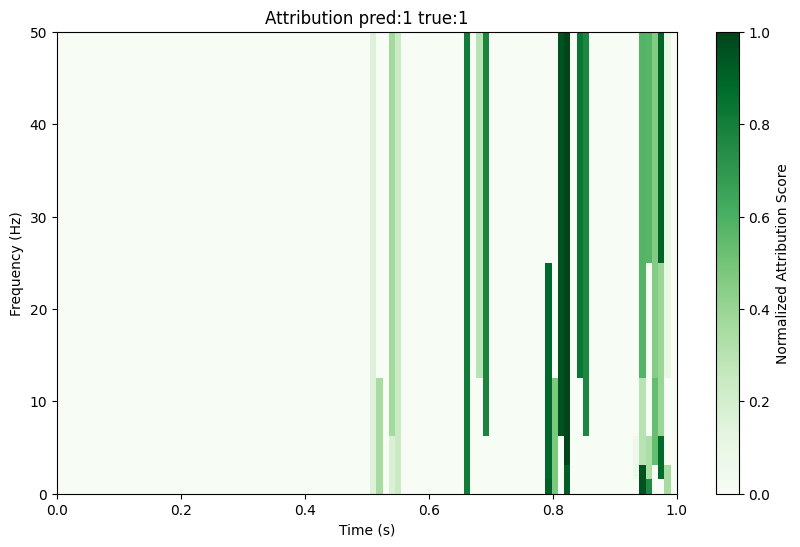

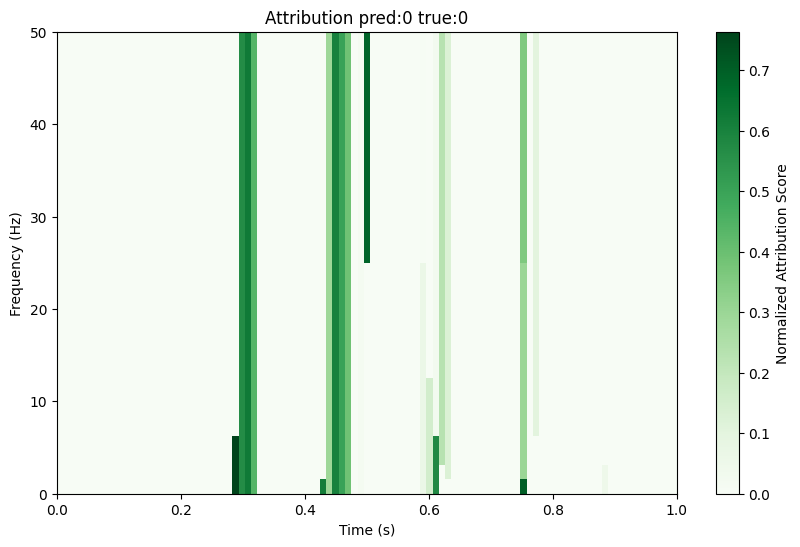

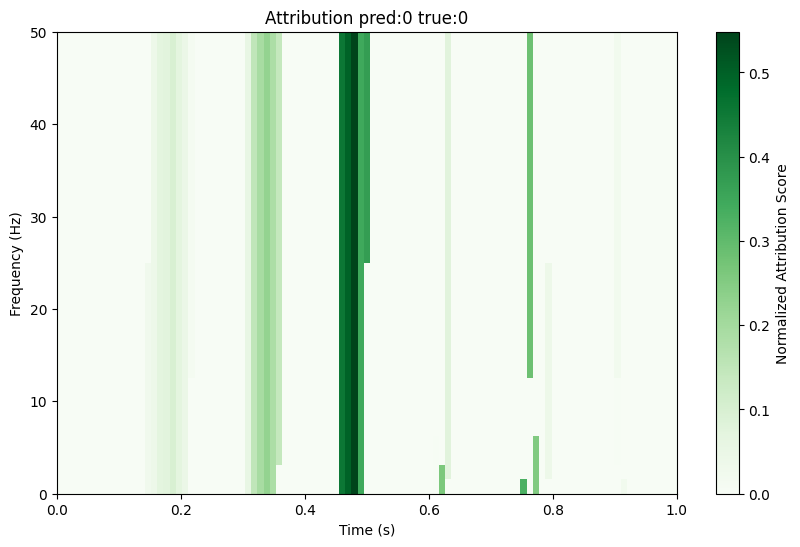

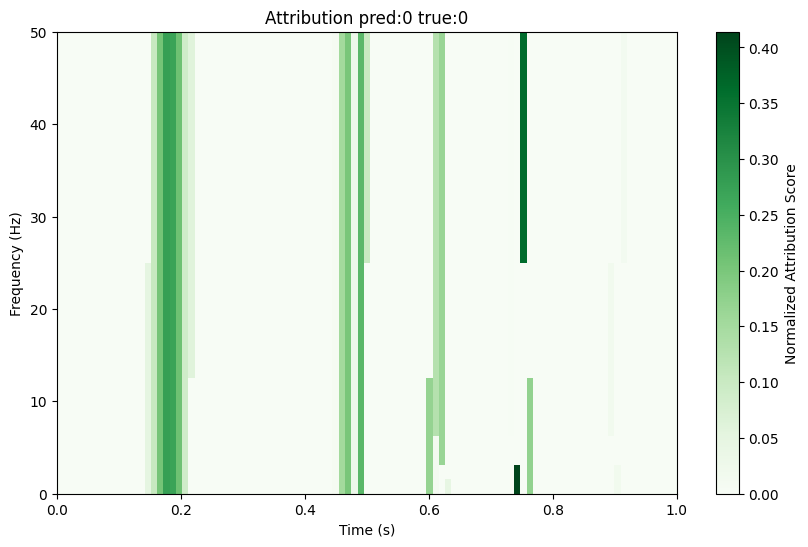

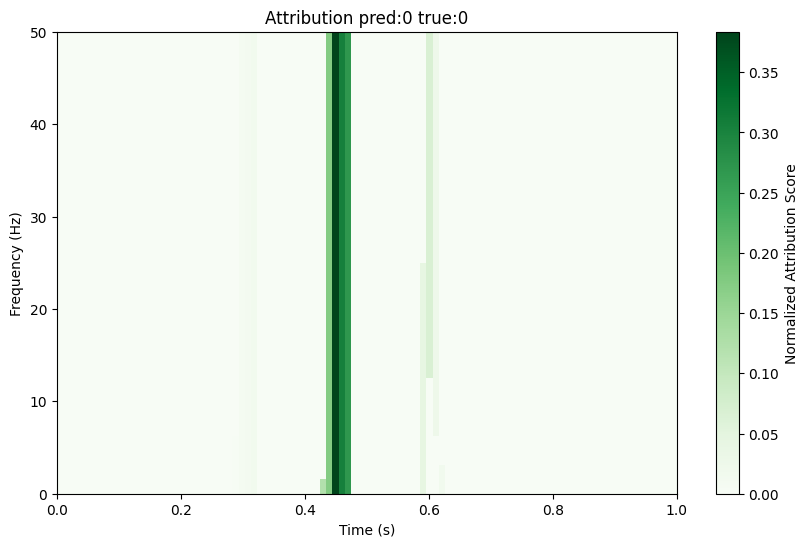

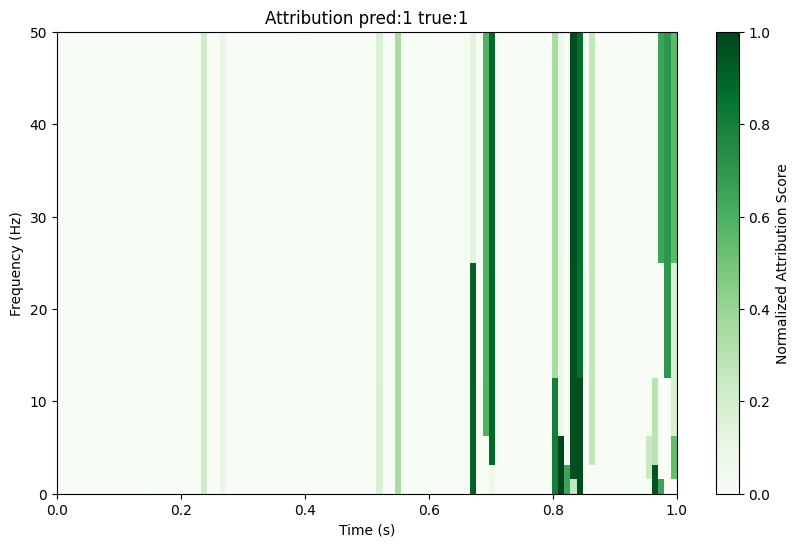

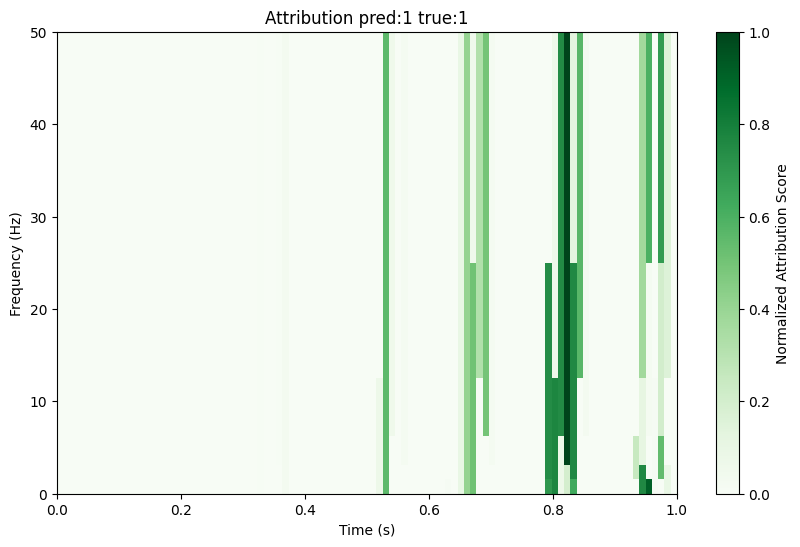

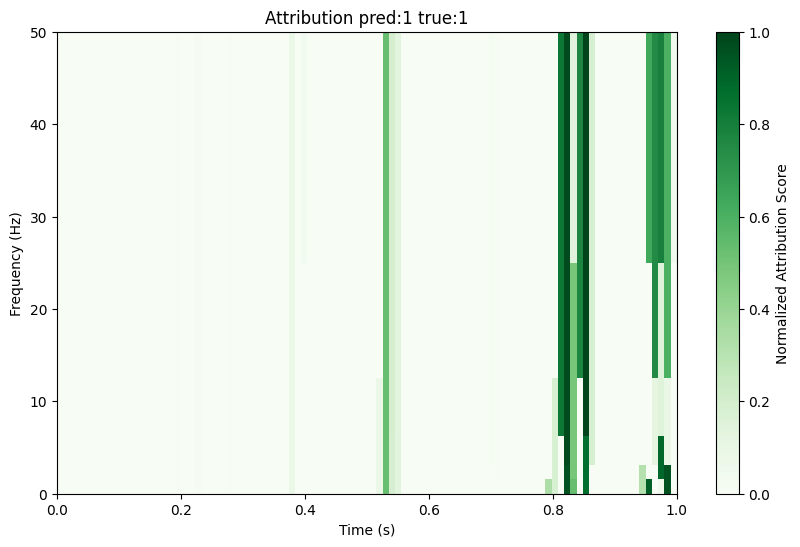

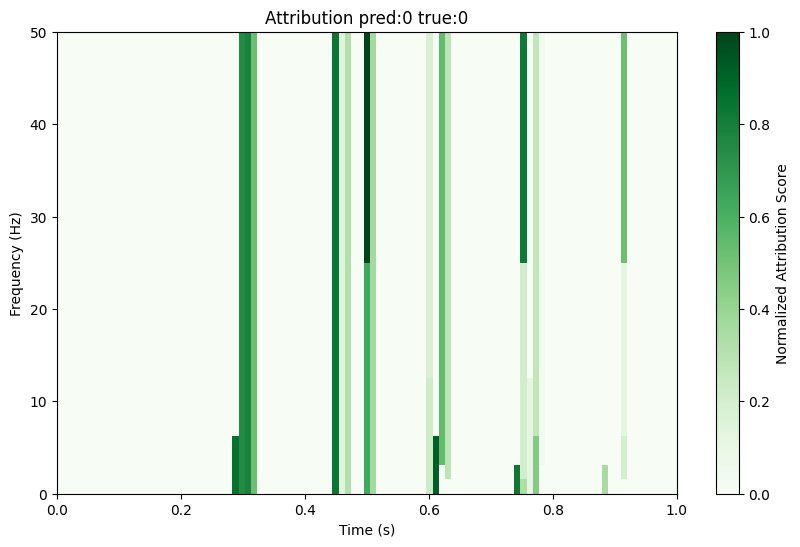

In [16]:
# plot the scores as a heatmap on the original signal
fs = 100
max_level = pywt.dwt_max_level(fs, 'db1')

# plot 5 samples
for i in range(1, 10):
    plot_scaleogram_wav_heatmap(fs, attributions['filtermasks_wavelet_db1_6_128'][0][i], prediction=attributions['predictions'][i].argmax(), label=attributions['labels'][i], fs=fs, level=max_level)


In [20]:
counts_0 = 0
counts_1 = 0

print(len(attributions['labels']))

for i in range(len(attributions['labels'])):
    if attributions['labels'][i] == 0:
        counts_0 += 1
    else:
        counts_1 += 1

print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")

10000
Counts of label 0: 5000, label 1: 5000


wavelet_db1_6_128


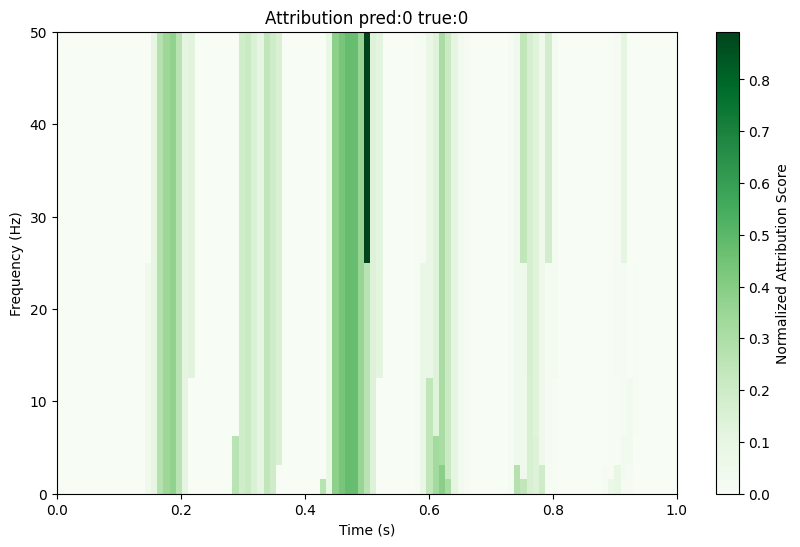

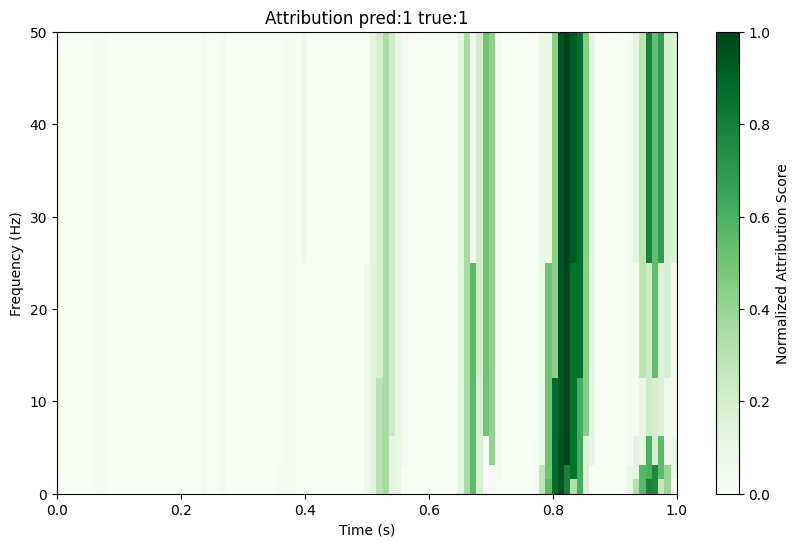

wavelet_db2_5_128


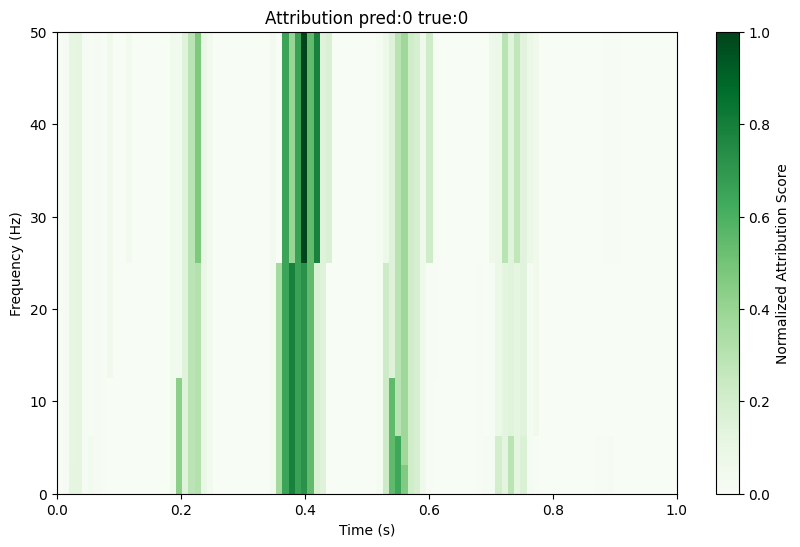

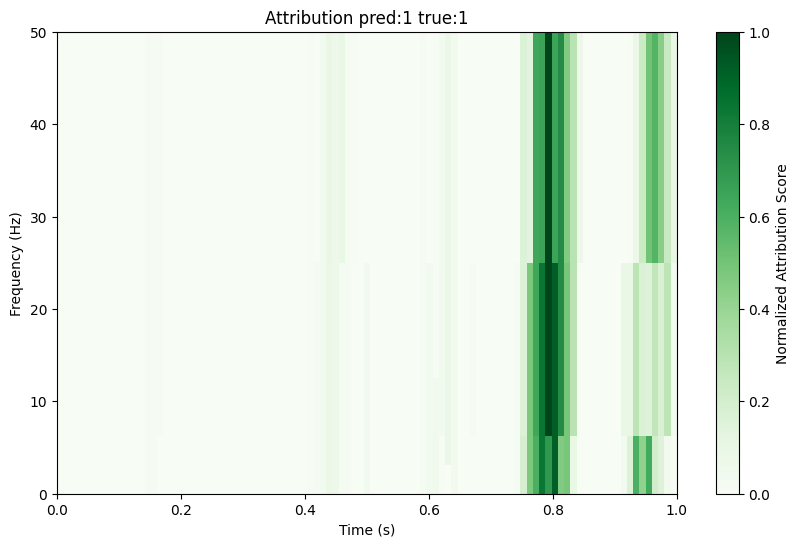

wavelet_db3_4_128


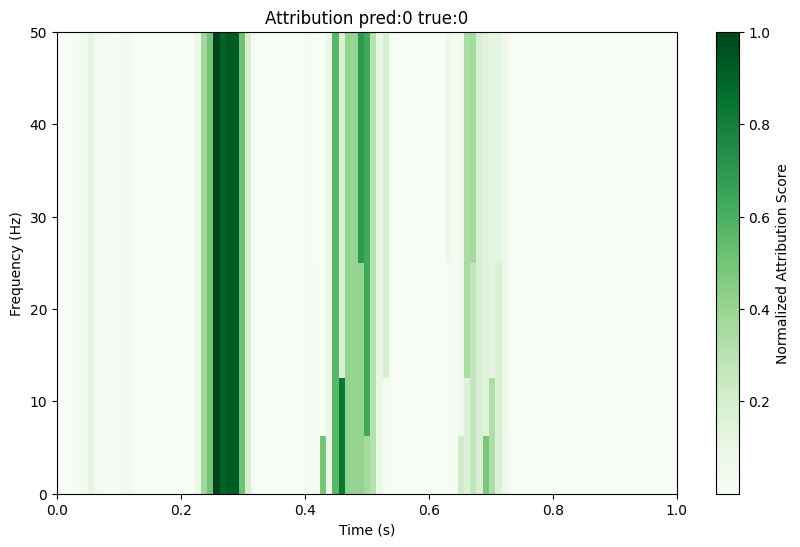

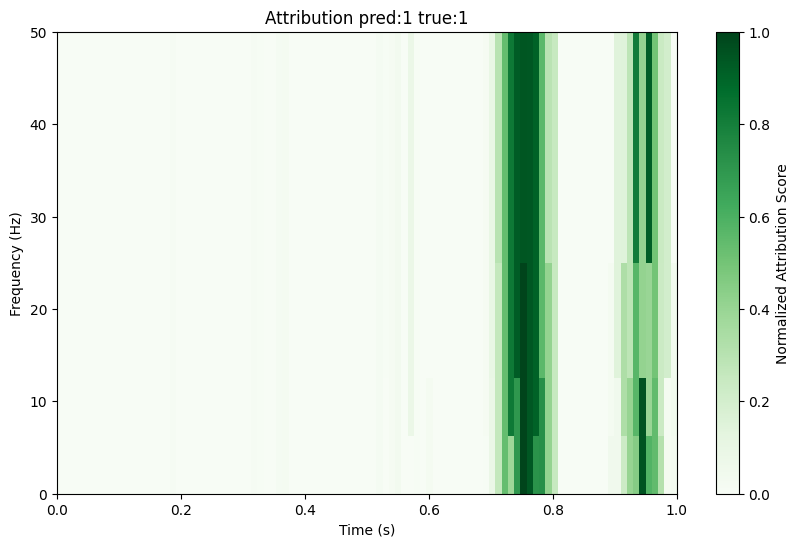

wavelet_db4_3_128


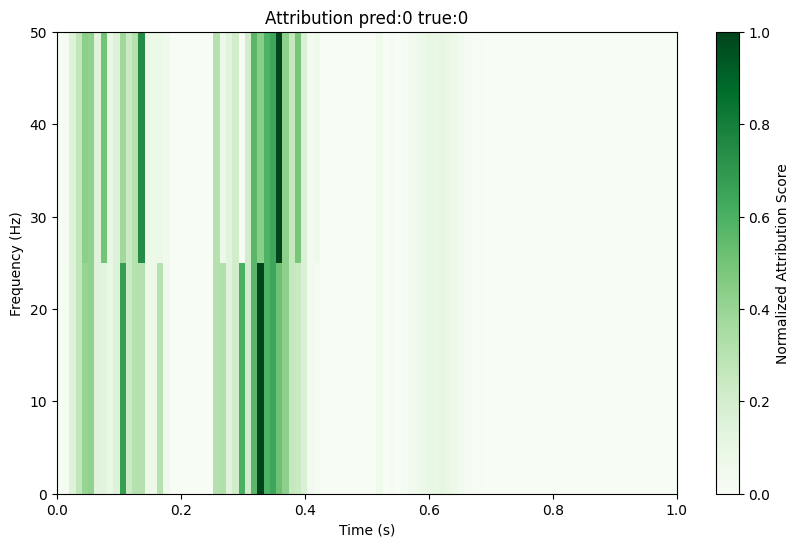

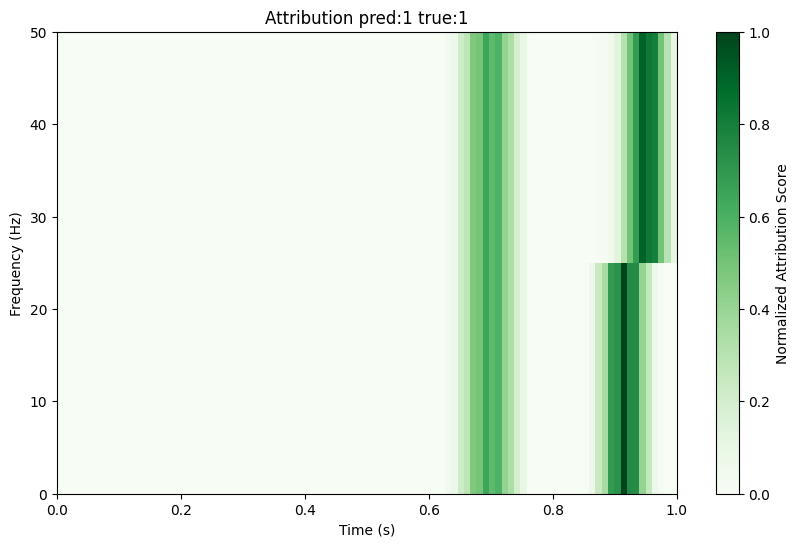

wavelet_sym2_5_128


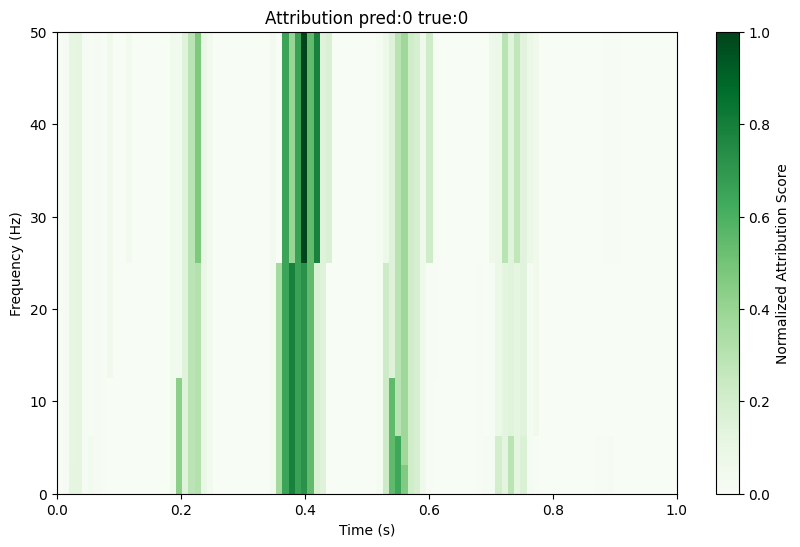

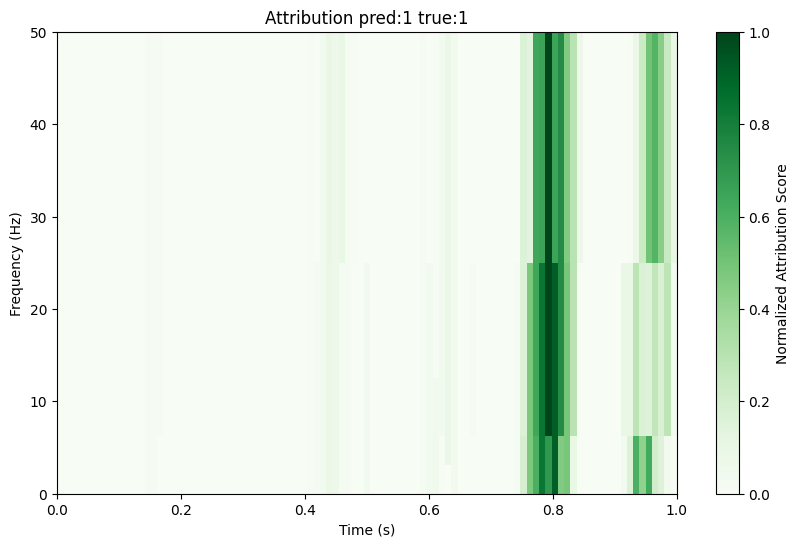

wavelet_sym3_4_128


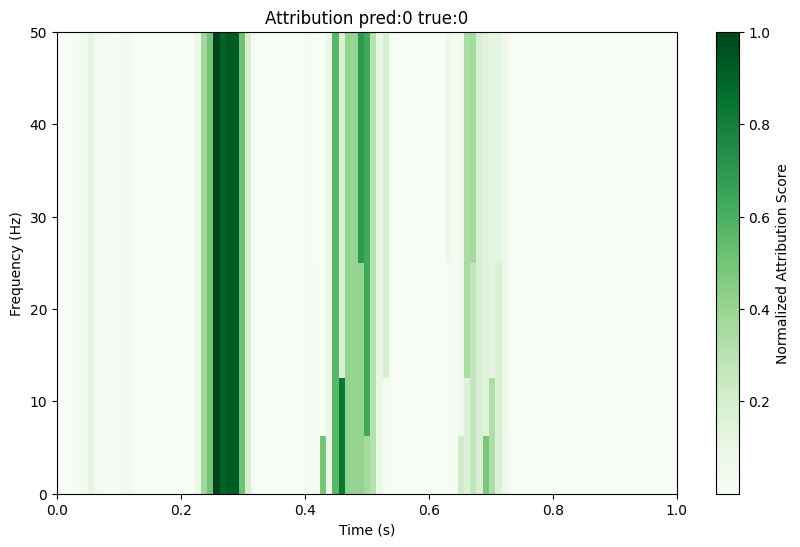

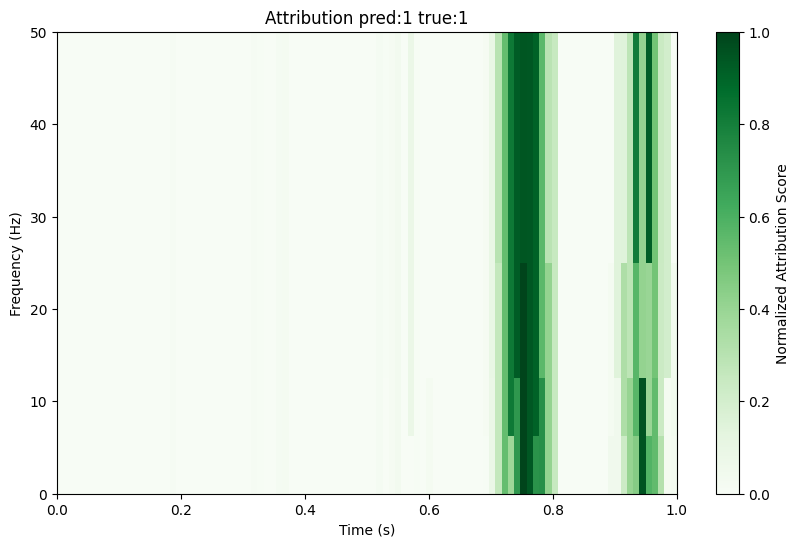

wavelet_sym4_3_128


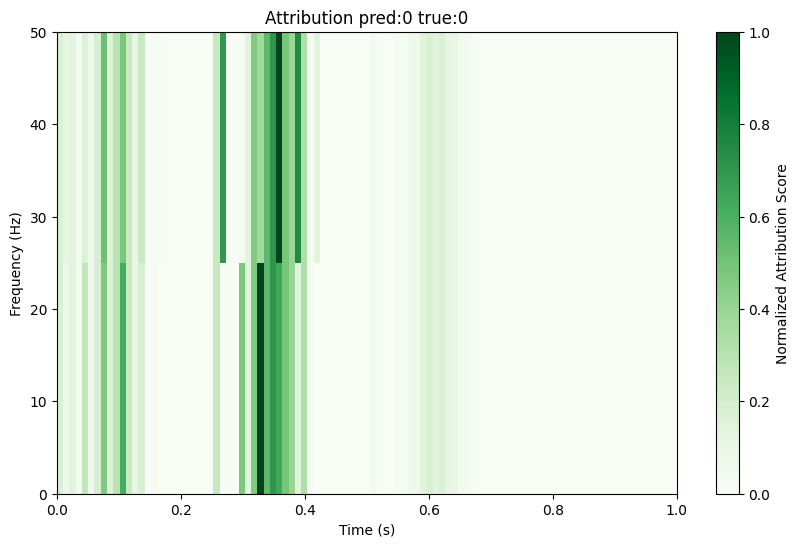

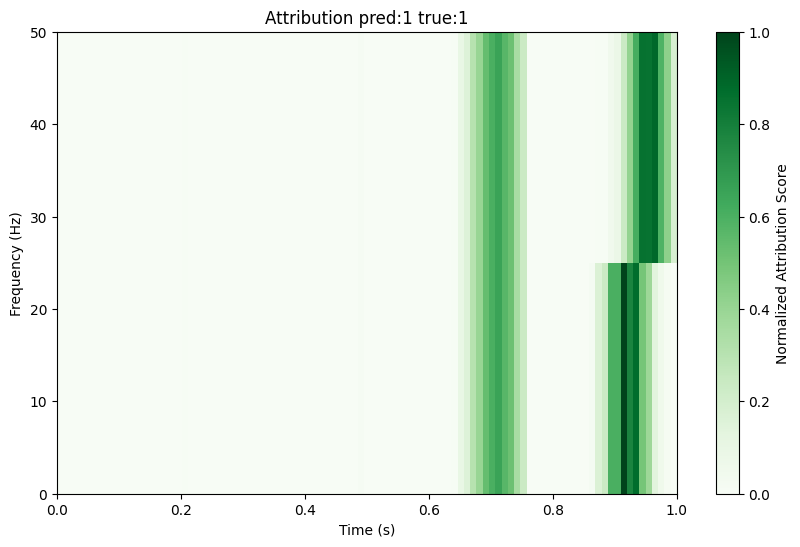

wavelet_coif1_4_128


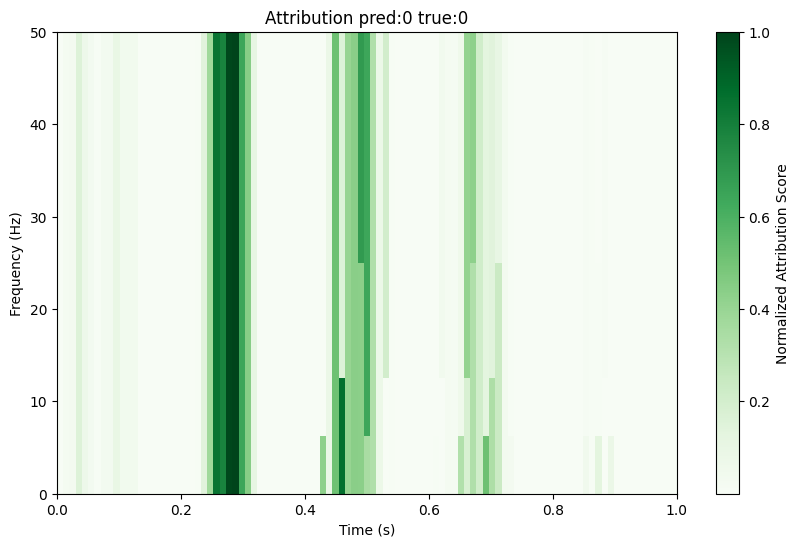

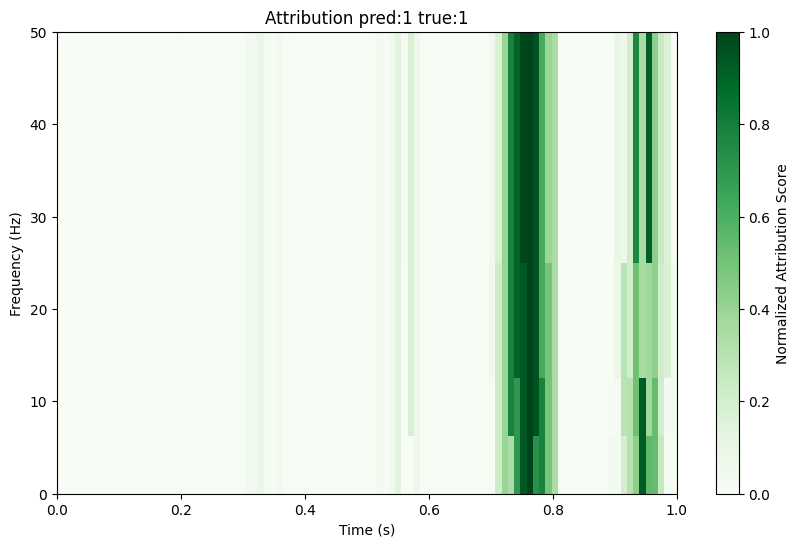

wavelet_coif2_3_128


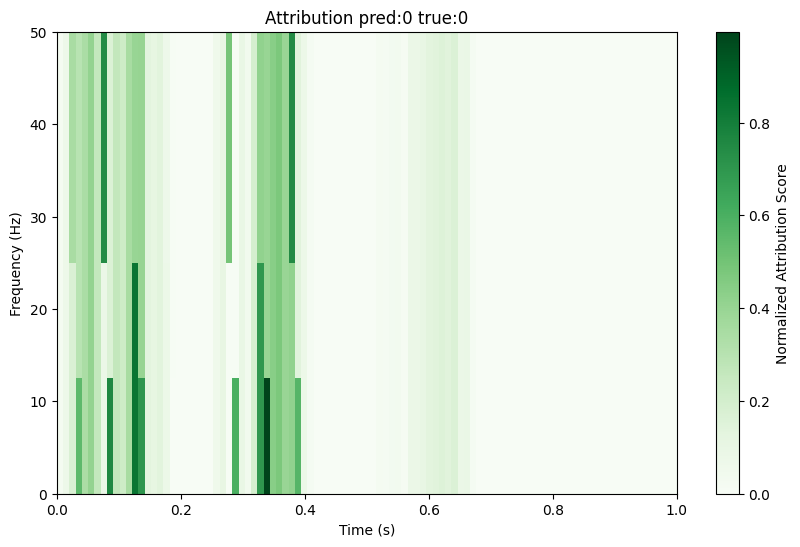

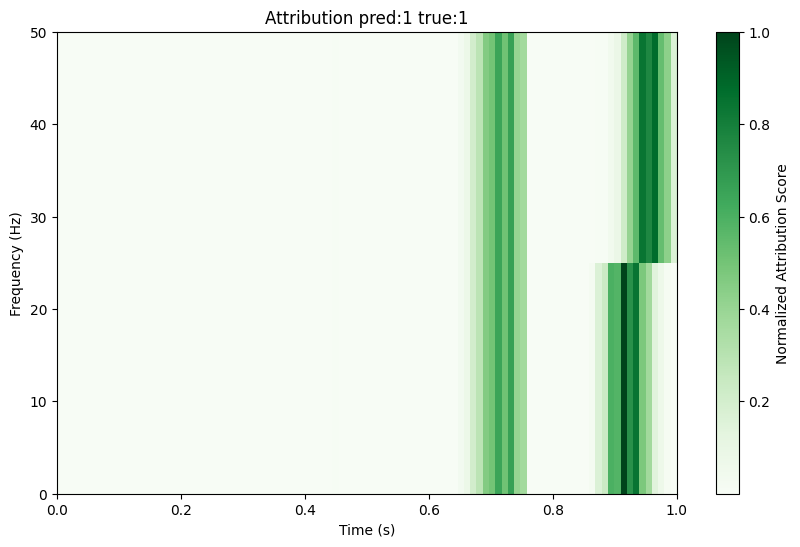

wavelet_coif3_2_128


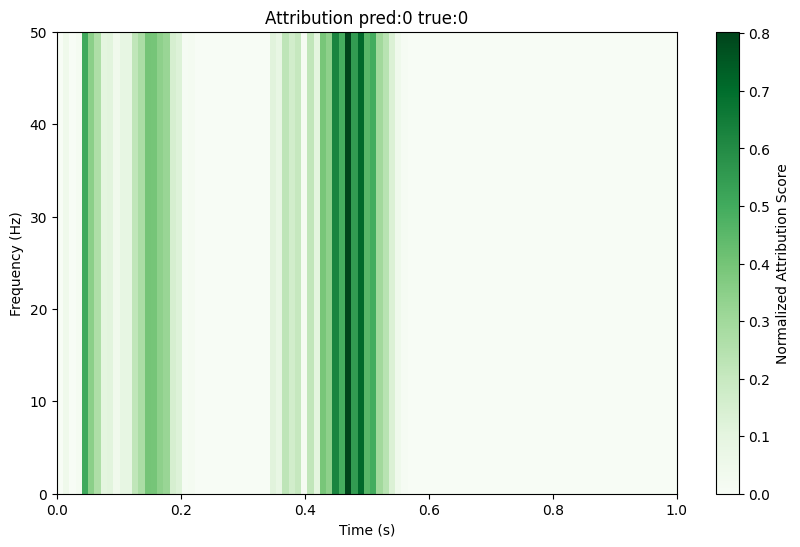

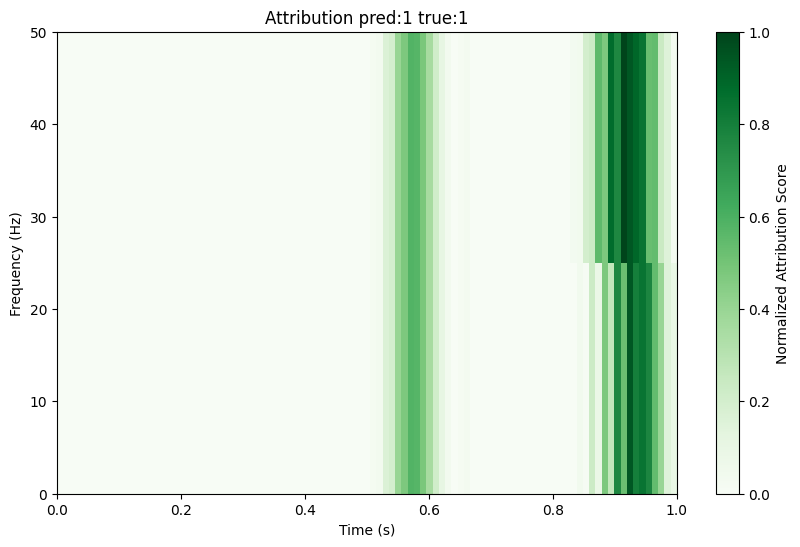

In [31]:
for key in attributions['insertion'].keys():
    print(key)

    method, wavelet, max_level, batch_size = key.split('_')
    max_level = int(max_level)

    key_ = f'filtermasks_{key}'

    masks_0 = np.zeros_like(attributions[key_][0][0])
    masks_1 = np.zeros_like(attributions[key_][0][0])

    index = 0

    for i in range(len(attributions[key_])):
        for j in range(len(attributions[key_][i])):
            # print(index)
            if attributions['labels'][index] == 0:
                masks_0 += attributions[key_][i][j]
            else:
                masks_1 += attributions[key_][i][j]

            index += 1

    masks_0 /= counts_0
    masks_1 /= counts_1

    plot_scaleogram_wav_heatmap(fs, masks_0, prediction=0, label=0, fs=fs, level=max_level)
    plot_scaleogram_wav_heatmap(fs, masks_1, prediction=1, label=1, fs=fs, level=max_level)



In [28]:
def compute_entropy_sample(attribution, epsilon=1e-10):
    abs_attr = np.abs(attribution)
    sum_attr = np.sum(abs_attr) + epsilon
    prob_dist = abs_attr / sum_attr
    entropy = -np.sum(prob_dist * np.log(prob_dist + epsilon))
    return entropy

In [29]:
# Compute the entropy-based complexity
complexity_scores = []

for i in range(len(attributions[key_])):
    attr = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    scores = []
    # print(attributions[key_][i].shape)
    for sample in attr:
        sample = sample.detach().cpu().numpy()
        c = compute_entropy_sample(sample)
        c = np.nan_to_num(c)
        scores.append(c)
    complexity_scores += scores

# compute the mean
mean_complexity = np.mean(complexity_scores)
print("Complexity Scores:")
print(mean_complexity)

Complexity Scores:
1.7638547


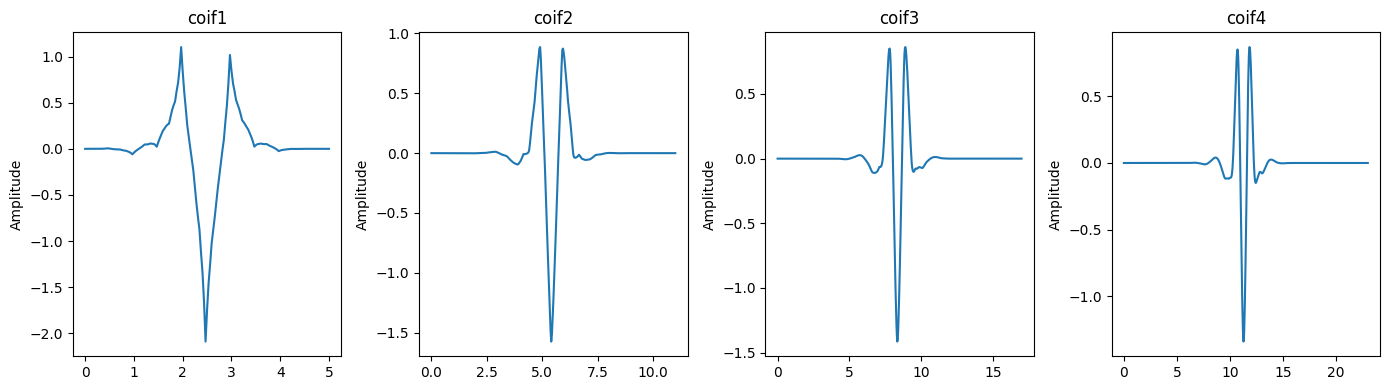

In [96]:
import pywt

# plot the db family wavelets from db1 to db4
def plot_wavelet_families(wavelet_families=['db'], wavelet_orders=None):
    plt.figure(figsize=(14, 4))

    for family in wavelet_families:
        for order in wavelet_orders:
            wavelet_name = f'{family}{order}'
            wavelet = pywt.Wavelet(wavelet_name)
            phi, psi, x = wavelet.wavefun(level=5)

            plt.subplot(len(wavelet_families), len(wavelet_orders), 
                        wavelet_families.index(family) * len(wavelet_orders) + (order ))
            # plt.plot(x, phi, label='Scaling Function')
            plt.plot(x, psi, label='Wavelet Function')
            plt.title(f'{wavelet_name}')
            # plt.xlabel('x')
            # plt.legend()
            plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Call the function to plot wavelet families
plot_wavelet_families(['coif'], [1, 2, 3, 4])

In [50]:
print(pywt.dwt_max_level(3000, 'coif6'))

6


['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3

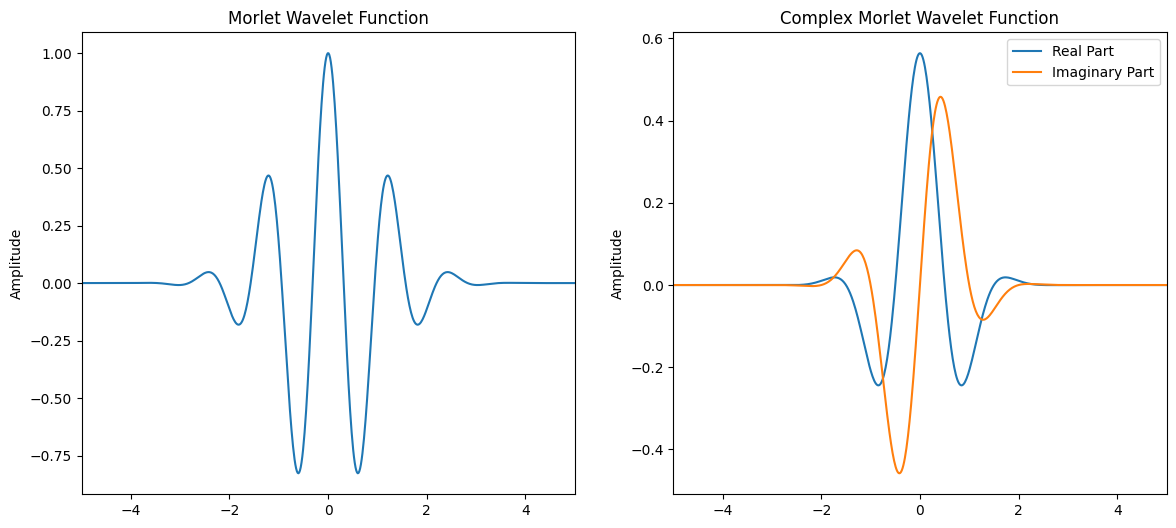

In [77]:
import pywt


print(pywt.wavelist())

# plot the morlet wavelet
morlet_wavelet = pywt.ContinuousWavelet('morl')
print(morlet_wavelet)

phi, x = morlet_wavelet.wavefun(level=10)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(x, phi, label='Morlet Wavelet Function')
plt.title('Morlet Wavelet Function')
plt.ylabel('Amplitude')
plt.xlim([-5, 5])

# plot the complex morlet wavelet
complex_morlet_wavelet = pywt.ContinuousWavelet('cmor1.0-0.5')
print(complex_morlet_wavelet)
phi, x = complex_morlet_wavelet.wavefun(level=10)
plt.subplot(1, 2, 2)
plt.plot(x, phi.real, label='Real Part')
plt.plot(x, phi.imag, label='Imaginary Part')
plt.title('Complex Morlet Wavelet Function')
plt.ylabel('Amplitude')
plt.xlim([-5, 5])
plt.legend()
plt.show()

